In [2]:
!pip install mnist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
#import mkl

#mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [4]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

### Activation functions

In [5]:
def sigmoid(batch):
    return 1.0 / (1.0 + np.exp(-batch))

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

# MNIST dataset

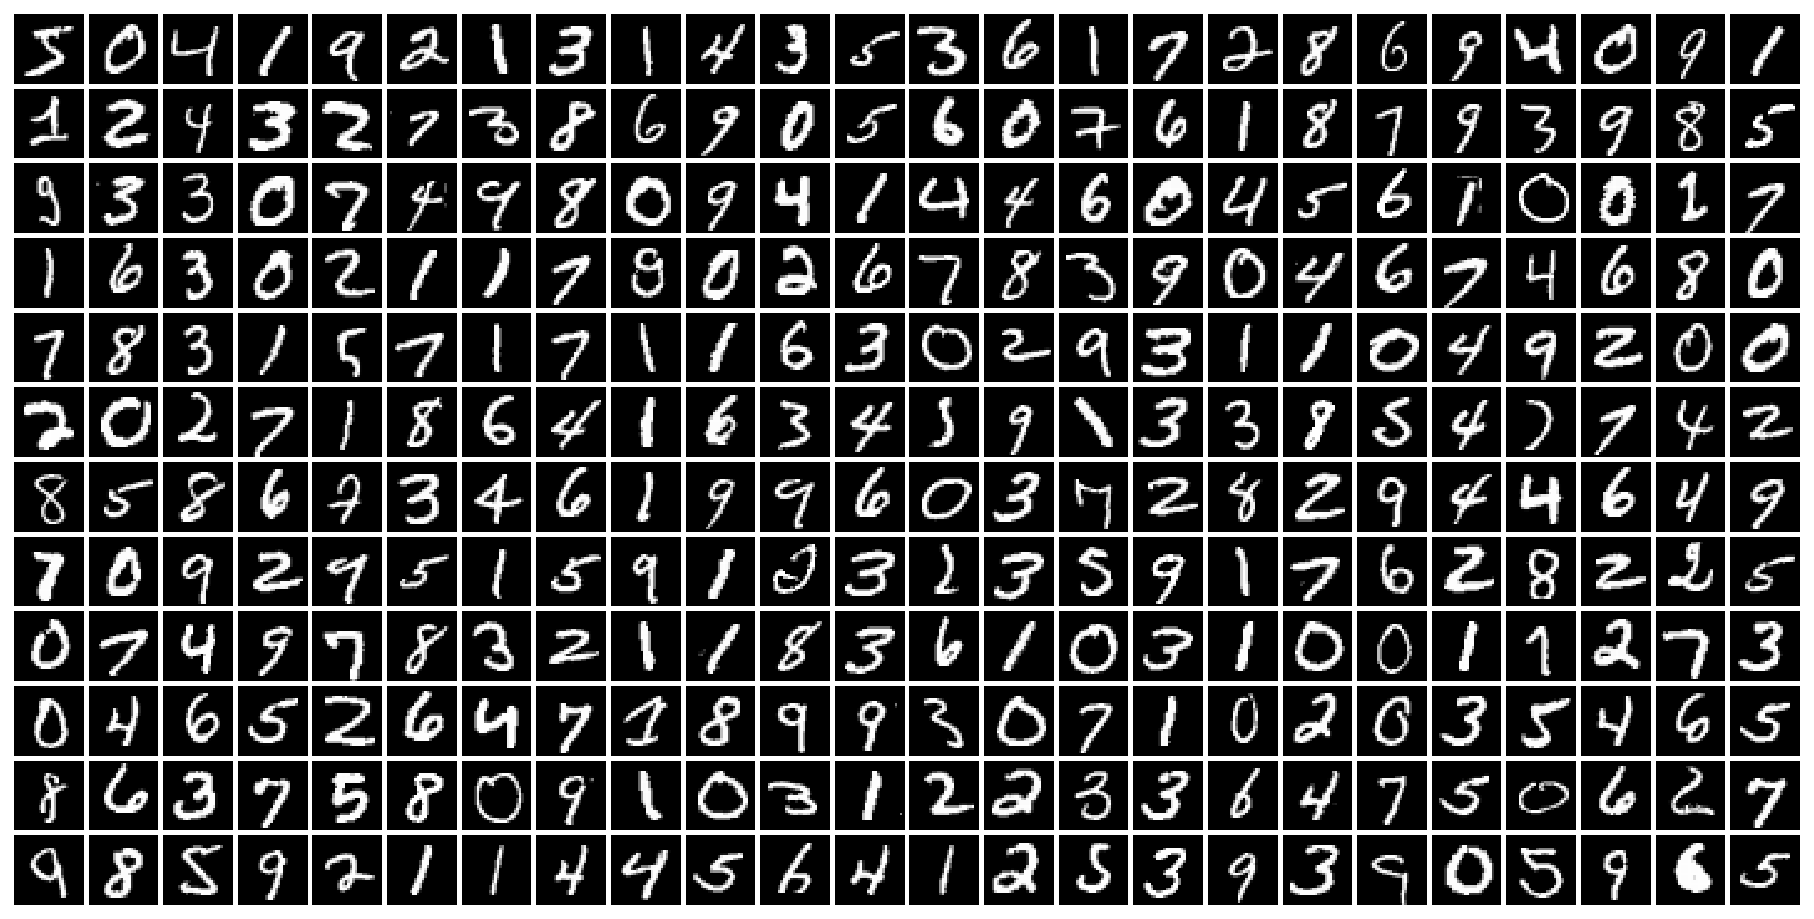

In [6]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Part 1: $L^1$ and $L^2$ penalties

In [7]:
class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate, momentum, l1_penalty, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l1_penalty = l1_penalty  # Stałe do trenowania wsteczną propagacją błędu
        self.l2_penalty = l2_penalty
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size+1, self.hidden_size+1) 

In [8]:
# Funkcja skopiowana z laboratorium SiNiUG_lab4.ipynb

def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))


    hidden[:,:-1] = sigmoid(minibatch @ rbm.W[:,:-1])
    visible = sigmoid(hidden @ rbm.W.T[:,:-1])

    error = np.sum( (minibatch[:,:-1] - visible)**2 ) / observations_count

    return error

In [9]:
def train_epoch(rbm, dataset, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time
        
        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

### CDK with regulatization

Implement the Contrastive Divergence algorithm with $L^1$ and $L^2$ penalties. If
```python
rbm.l1_penalty > 0
```
the algorithm should constrain the weights with $L^1$ penalty. Otherwise, if
```python
rbm.l2_penalty > 0
```
the algorithm should constrain the weights with $L^2$ penalty.

Do **not** apply the penalties to the biases!

In [21]:
# Skopiowane z poprzednich laboratoriach i zmodyfikowane, aby uwzględniało koszty L1 i L2

def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch  # Dane wejściowe
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))
    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))


    # Faza pozytywna
    positive_hidden[:,:-1] = sigmoid(positive_visible @ rbm.W[:,:-1]) 
    delta_positive = positive_visible.T @ positive_hidden / observations_count


    # Faza negatywna
    negative_hidden = (positive_hidden  > rand(*positive_hidden.shape)).astype(np.float32)        # Negative Hidden nr. 0

    for i in range(k):
      negative_visible[:,:-1] = sigmoid(negative_hidden @ rbm.W.T[:,:-1])
      negative_visible = (negative_visible > rand(*negative_visible.shape)).astype(np.float32)    # Negative Visible nr. i

      negative_hidden[:,:-1] = sigmoid(negative_visible @ rbm.W[:,:-1])            # Negative Hidden nr. i
      if i != k-1:
        negative_hidden = (negative_hidden > rand(*negative_hidden.shape)).astype(np.float32) 

    delta_negative = negative_visible.T @ negative_hidden / observations_count


    rbm.M = (rbm.momentum * rbm.M) + (rbm.learning_rate * (delta_positive - delta_negative))

    # Jeśli l1 i l2 > 0 to bierz l1, jeśli l2 > 0 to bierz l2 ??? 
    if rbm.l1_penalty > 0:
      rbm.M[:-1, :-1] -= rbm.learning_rate * rbm.l1_penalty * np.sign(rbm.W[:-1, :-1])
    if rbm.l2_penalty > 0:
      rbm.M[:-1, :-1] -= rbm.learning_rate * rbm.l2_penalty * rbm.W[:-1, :-1]

    rbm.W = rbm.W + rbm.M

## Comparison of regularization penalties

In [22]:
DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

In [23]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

### RBM with no regularization

In [24]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_plain = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L1_PENALTY, L2_PENALTY)

run_training(rbm_plain, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 1.25s, reconstruction error: 24.55
Epoch 2:	########################################	elapsed: 1.46s, reconstruction error: 18.79
Epoch 3:	########################################	elapsed: 1.41s, reconstruction error: 16.20
Epoch 4:	########################################	elapsed: 1.47s, reconstruction error: 14.53
Epoch 5:	########################################	elapsed: 1.41s, reconstruction error: 13.50
Epoch 6:	########################################	elapsed: 1.42s, reconstruction error: 12.51
Epoch 7:	########################################	elapsed: 1.42s, reconstruction error: 11.44
Epoch 8:	########################################	elapsed: 1.41s, reconstruction error: 10.76
Epoch 9:	########################################	elapsed: 1.42s, reconstruction error: 10.30
Epoch 10:	########################################	elapsed: 1.42s, reconstruction error: 9.88
Epoch 11:	########################################	elapsed: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


################	elapsed: 1.17s, reconstruction error: 7.80
Epoch 38:	########################################	elapsed: 1.13s, reconstruction error: 7.86
Epoch 39:	########################################	elapsed: 1.14s, reconstruction error: 7.82
Epoch 40:	########################################	elapsed: 1.14s, reconstruction error: 7.68
Epoch 41:	########################################	elapsed: 1.12s, reconstruction error: 7.81
Epoch 42:	########################################	elapsed: 1.13s, reconstruction error: 7.60
Epoch 43:	########################################	elapsed: 1.12s, reconstruction error: 7.63
Epoch 44:	########################################	elapsed: 1.15s, reconstruction error: 7.54
Epoch 45:	########################################	elapsed: 1.16s, reconstruction error: 7.55
Epoch 46:	########################################	elapsed: 1.13s, reconstruction error: 7.66
Epoch 47:	########################################	elapsed: 1.14s, reconstruction error: 7.50


### RBM with $L^1$ penalty

In [25]:
L1_PENALTY = 0.0001
L2_PENALTY = 0.0

np.random.seed(1234)
rbm_l1 = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L1_PENALTY, L2_PENALTY)

run_training(rbm_l1, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 1.52s, reconstruction error: 24.60
Epoch 2:	########################################	elapsed: 1.50s, reconstruction error: 18.79
Epoch 3:	########################################	elapsed: 1.53s, reconstruction error: 16.22
Epoch 4:	########################################	elapsed: 1.49s, reconstruction error: 14.49
Epoch 5:	########################################	elapsed: 1.47s, reconstruction error: 13.52
Epoch 6:	########################################	elapsed: 1.50s, reconstruction error: 12.48
Epoch 7:	########################################	elapsed: 1.49s, reconstruction error: 11.33
Epoch 8:	########################################	elapsed: 1.51s, reconstruction error: 10.66
Epoch 9:	########################################	elapsed: 1.46s, reconstruction error: 10.12
Epoch 10:	########################################	elapsed: 1.48s, reconstruction error: 9.70
Epoch 11:	########################################	elapsed: 

### RBM with $L^2$ penalty

In [26]:
L1_PENALTY = 0.0
L2_PENALTY = 0.0005

np.random.seed(1234)
rbm_l2 = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM, L1_PENALTY, L2_PENALTY)

run_training(rbm_l2, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

Epoch 1:	########################################	elapsed: 1.27s, reconstruction error: 24.56
Epoch 2:	########################################	elapsed: 1.26s, reconstruction error: 18.82
Epoch 3:	########################################	elapsed: 1.28s, reconstruction error: 16.25
Epoch 4:	########################################	elapsed: 1.25s, reconstruction error: 14.63
Epoch 5:	########################################	elapsed: 1.24s, reconstruction error: 13.59
Epoch 6:	########################################	elapsed: 1.24s, reconstruction error: 12.56
Epoch 7:	########################################	elapsed: 1.22s, reconstruction error: 11.46
Epoch 8:	########################################	elapsed: 1.22s, reconstruction error: 10.83
Epoch 9:	########################################	elapsed: 1.23s, reconstruction error: 10.33
Epoch 10:	########################################	elapsed: 1.26s, reconstruction error: 9.90
Epoch 11:	########################################	elapsed: 

### Plain filters

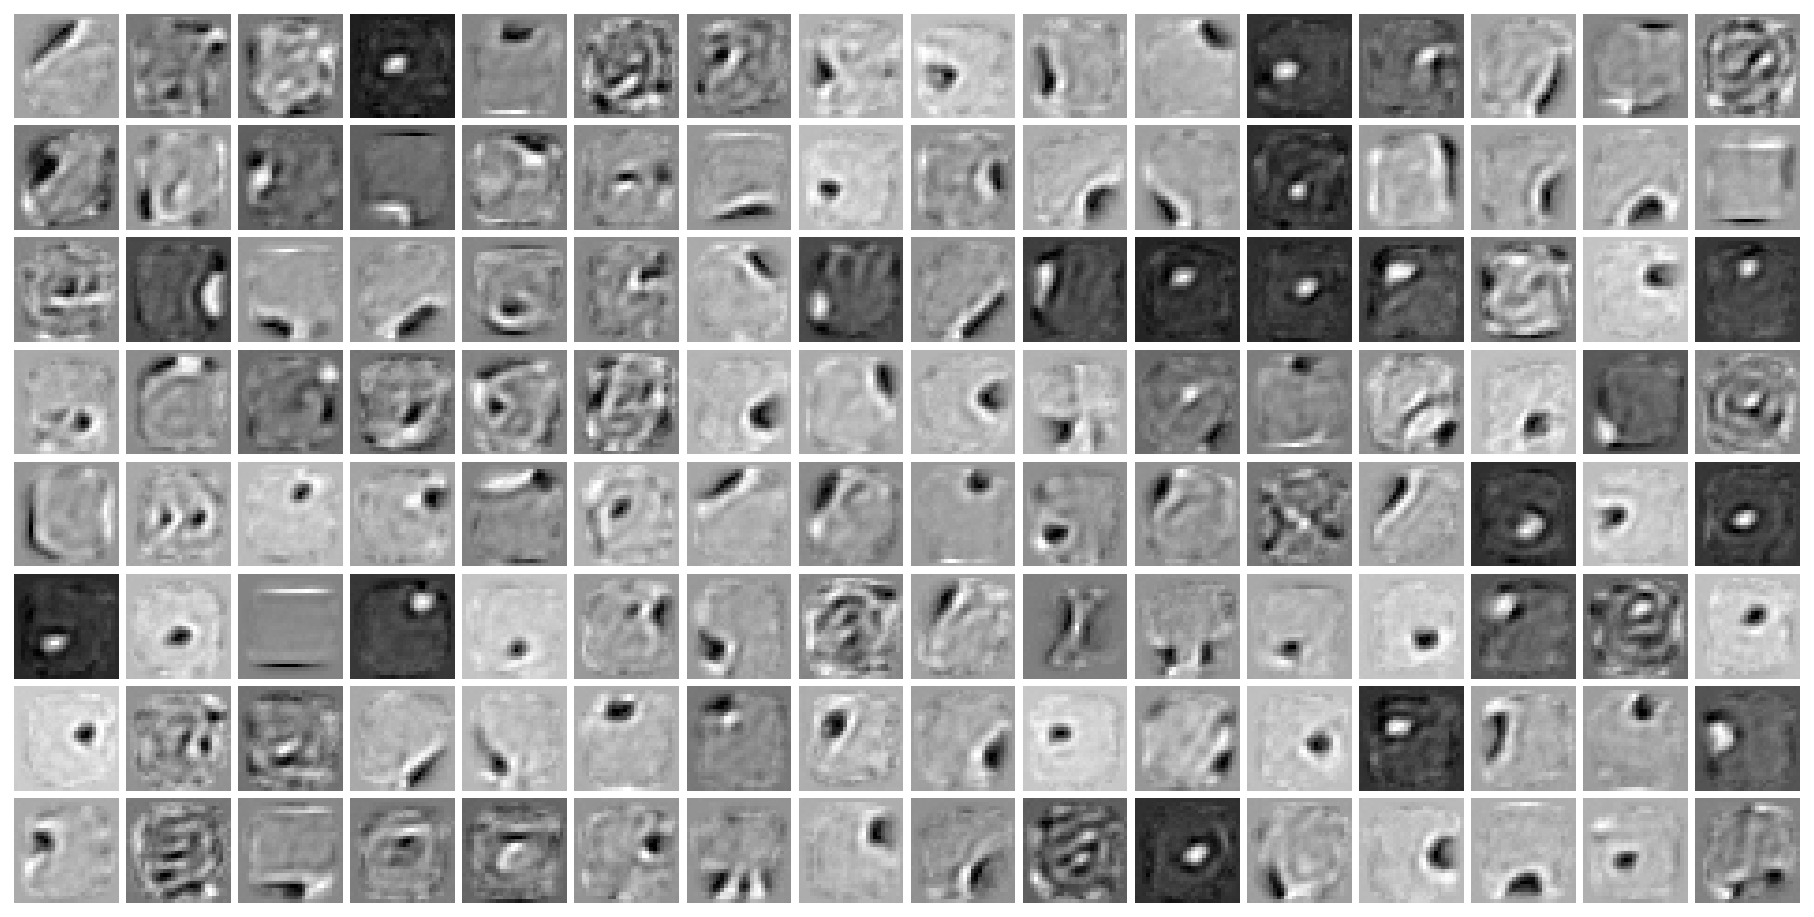

In [27]:
draw_filters(rbm_plain)

### $L^1$ filters

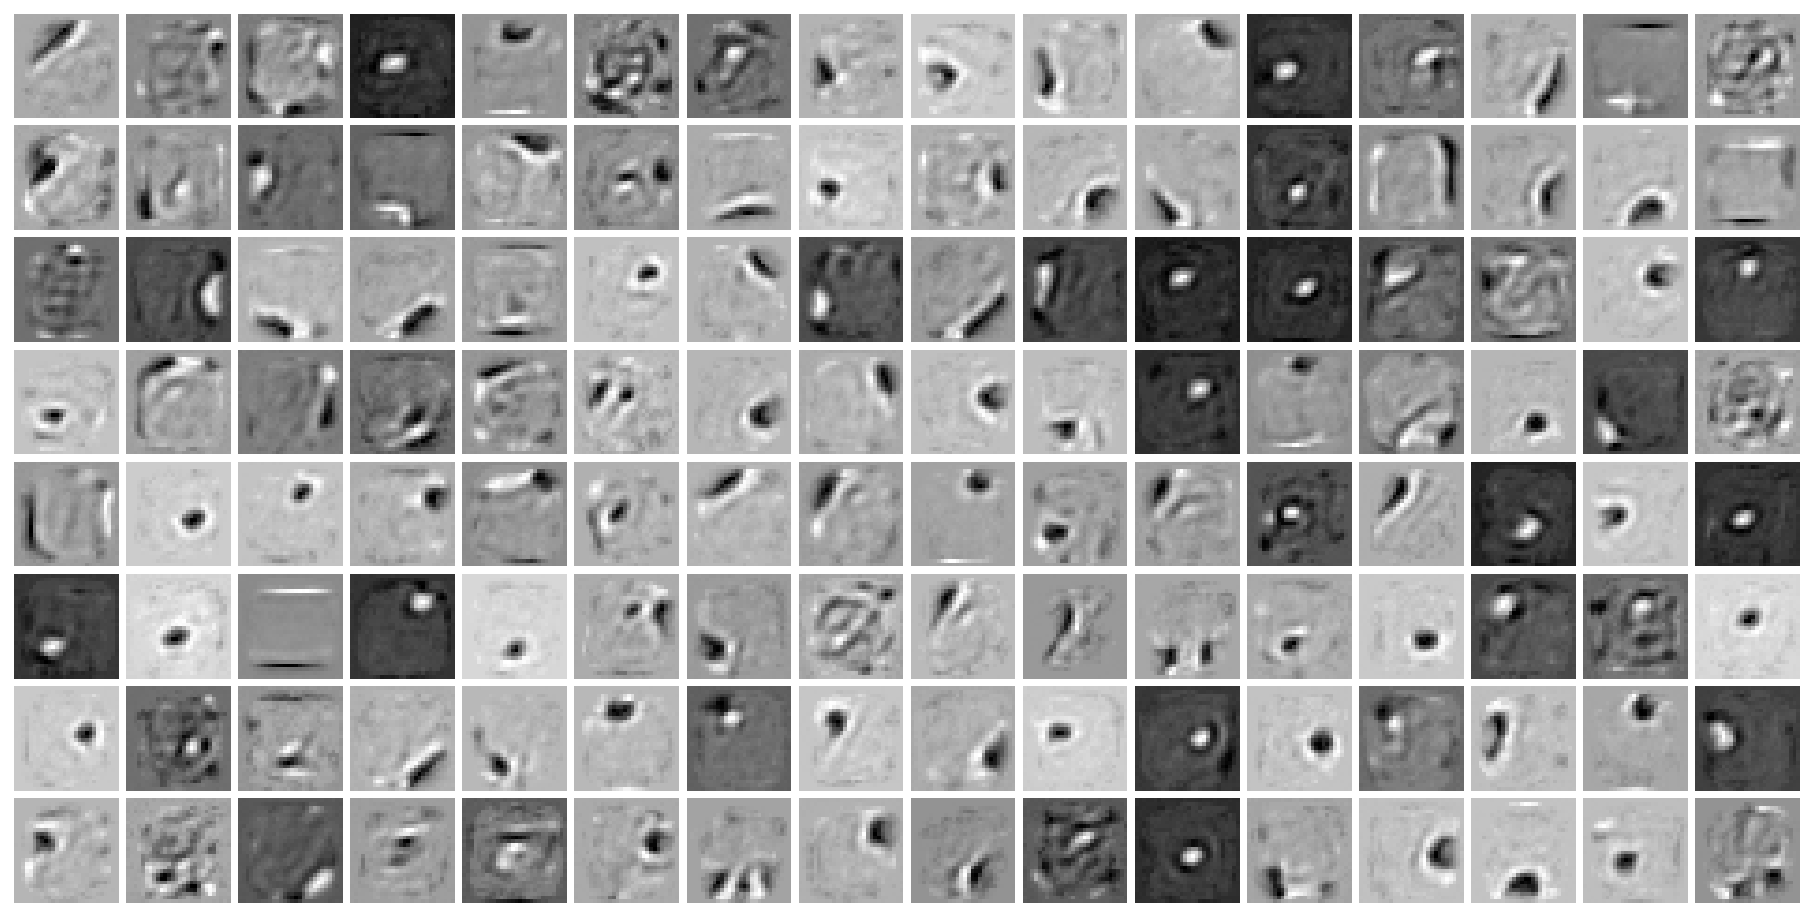

In [28]:
draw_filters(rbm_l1)

### $L^2$ filters

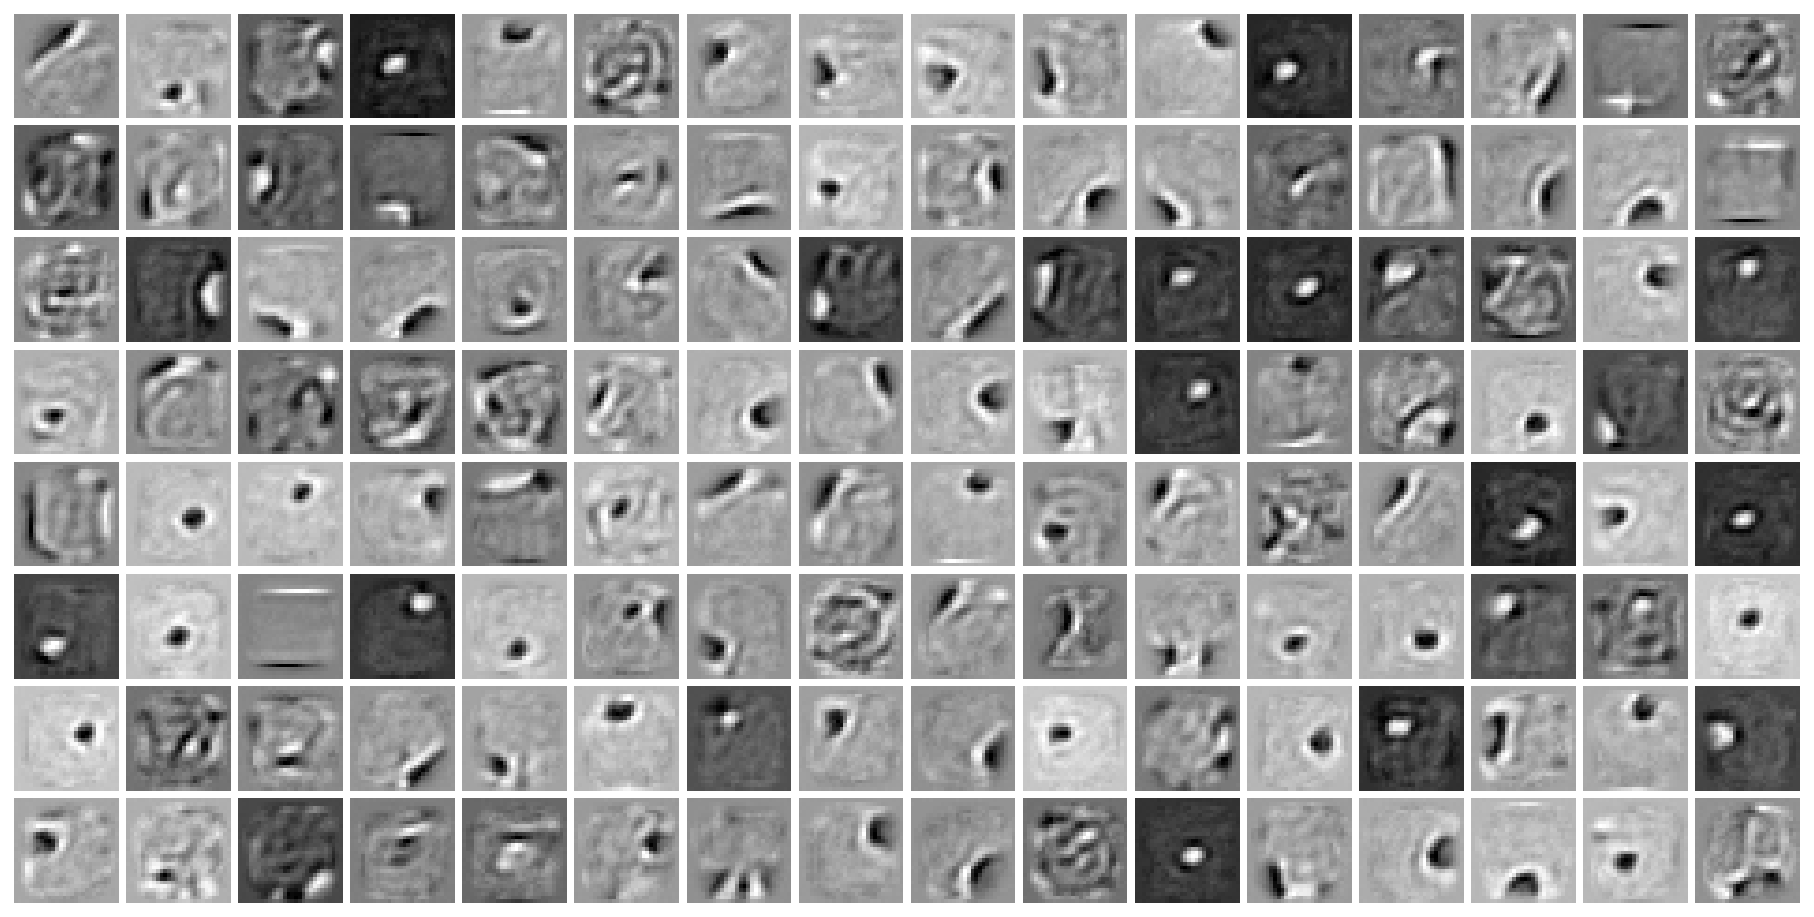

In [29]:
draw_filters(rbm_l2)

# Part 2: MLP pretraining

In [19]:
# Skopiowane z SiNiUG_lab6.ipynb
def softmax(batch):
    max_value = np.max(batch, axis=1, keepdims=True)
    z = batch - max_value
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=1, keepdims=True)
    softmax = numerator/denominator
    return softmax

In [20]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 learning_rate, momentum, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l2_penalty = l2_penalty # Każda warstwa może być regularyzowana L2
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size+1, self.hidden_size)

### Forward pass

In [30]:
# Weź z poprzedniego labu i (może) zmodyfikuj (nie modyfikowałem)

# Skopiowana z SiNiUG_lab6.ipynb
def forward_pass(mlp, batch, compute_derivatives):
    visible = batch
    
    for layer_idx, layer in enumerate(mlp):
        #raise Exception('Compute layer activations here!')
        z = visible @ layer.W
        layer.activations = append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(mlp) - 1):
            #raise Exception('Remember about the derivatives of the activation function!')
            layer.d_activations = layer.d_activation_fun(z)
        
        visible = layer.activations
        
    return visible[:, :-1]

### Error backpropagation

Extend the implementation of error backpropagation (from Lab 6) with $L^2$ penalty. Apply the penalty when:
```python
rbm.l2_penalty > 0
```

Do **not** apply the penalty to the biases.

In [31]:
# Wzięte z SiNiUG_lab6.ipynb i zmodyfikowane
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]
    #error('Error backpropagation is unimplemented')
    
    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations
            
            #raise Exception("Calculate the deltas in 'prev_layer'")
            prev_layer.deltas = (layer.deltas @ layer.W[:-1].T) * prev_layer.d_activations
        else:
            visible = batch
        
        #raise Exception("Update the momentum matrix with gradient from error backpropagation")
        gradient = (visible.T @ layer.deltas) / observations_count
        layer.M = layer.momentum * layer.M - layer.learning_rate * gradient

        if layer.l2_penalty > 0:
          layer.M[:-1, :] -= layer.learning_rate * layer.l2_penalty * layer.W[:-1, :]
        
        layer.W += layer.M

### MLP training

In [32]:
# Skopiowane z SiNiUG_lab6.ipynb
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        y = forward_pass(mlp, batch, True)
        
        #raise Exception("Delta in the sofmax layer is unimplemented!")
        mlp[-1].deltas = y - batch_labels
        
        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch)
        
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

In [33]:
def classify(mlp, batch):
    probabilities = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)

def run_mlp_training(mlp, train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count):
    
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 5:
            for layer in mlp: layer.momentum = 0.9
        
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")
    
def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))
    tiles(filters)

## DBN Pretraining

In [34]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
    return visible

def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(sigmoid(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

In [35]:
# Skopiowane z SiNiUG_lab5.ipynb
def dbn_reconstuction_error(dbn, layers_count, minibatch):
    #raise Exception("Not implemented!")
    shifted_nodes = propagate_up(dbn, layers_count, minibatch)
    error = reconstuction_error(dbn[layers_count], shifted_nodes)
    
    return error

In [37]:
# Skopiowana `train_dbn` z SiNiUG_lab5.ipynb
def train_dbn_layer(dbn, layer_idx, dataset, batch_size):
    
    dataset = propagate_up(dbn, layer_idx, dataset)

    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

In [38]:
def train_dbn(dbn, dataset, monitoring_set, batch_size, epochs_count):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))
        
        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch+1),  end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))  

##  Initializing MLP with DBN weights

Implement initialization of MLP weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the MLP weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [39]:
def initialize_mlp(mlp, dbn):
  # Dostaje dbna i mlp - sekwencja warst
  # Zainicjalizuj mlp za pomocą wag dbn'a - ostatnia część poniedziałkowego wykładu
  # Wagi w mlp w liście Layer , skopiuj wagi z dbna niektóre elementy usuwając
  # Uwaga w numpy: Layer.podstaw dbn.w tylko PODSTAWIA REFERENCJE!!! - zadbaj o kopię
  for layer, rbn in zip(mlp, dbn):
    layer.W = np.copy(rbn.W[:, :-1])

# MNIST digits classification

In [40]:
np.random.seed(1234)

DATASET_SIZE = 10000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

### Plain vs pretrained MLP comparison

In [41]:
from IPython.core.display import HTML

def compare_pretraining_results(mlp, dbn,
                                train_set, train_labels,
                                validation_set, validation_labels,
                                monitoring_set,
                                batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>Plain MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in the plain MLP</h3>'))
    draw_layer_filters(mlp[0])
    
    display(HTML('<h3>DBN training</h3>'))
    train_dbn(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    for layer in mlp:
        layer.reset()
    
    initialize_mlp(mlp, dbn)
    
    display(HTML('<h3>Finetuning pretrained MLP</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>First layer filters in the DBN</h3>'))
    draw_filters(dbn[0])
    
    display(HTML('<h3>Input layer filters in the pretrained & finetuned MLP</h3>'))
    draw_layer_filters(mlp[0])

In [42]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5
L2_PENALTY = 0.00002

### Shallow neural network

Epoch 1:	########################################	elapsed: 0.58s, accuracy: 10.10
Epoch 2:	########################################	elapsed: 0.57s, accuracy: 10.10
Epoch 3:	########################################	elapsed: 0.60s, accuracy: 8.92
Epoch 4:	########################################	elapsed: 0.57s, accuracy: 8.92
Epoch 5:	########################################	elapsed: 0.55s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.60s, accuracy: 15.02
Epoch 7:	########################################	elapsed: 0.54s, accuracy: 27.16
Epoch 8:	########################################	elapsed: 0.52s, accuracy: 31.92
Epoch 9:	########################################	elapsed: 0.60s, accuracy: 33.31
Epoch 10:	########################################	elapsed: 0.57s, accuracy: 46.90
Epoch 11:	########################################	elapsed: 0.54s, accuracy: 52.84
Epoch 12:	########################################	elapsed: 0.58s, accuracy: 58.70
Epoch 13:	#####

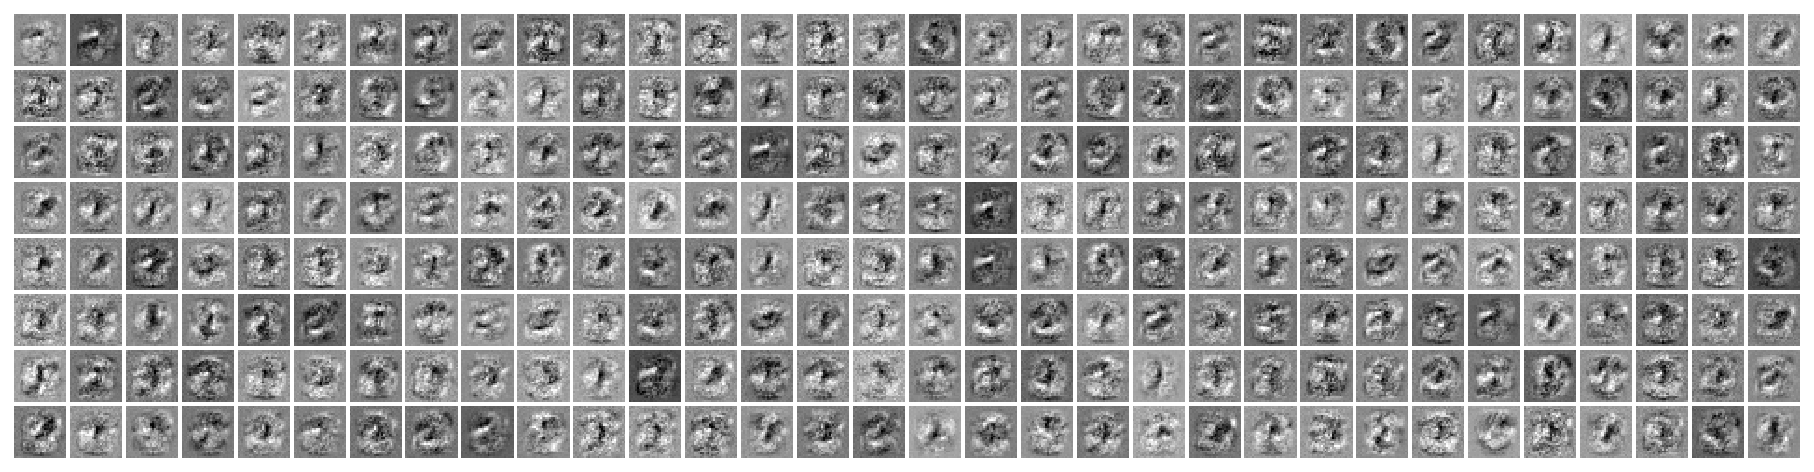


Learning layer 0
Epoch 1:	########################################	elapsed: 1.15s, reconstruction error: 30.69
Epoch 2:	########################################	elapsed: 1.06s, reconstruction error: 23.01
Epoch 3:	########################################	elapsed: 1.08s, reconstruction error: 19.27
Epoch 4:	########################################	elapsed: 1.62s, reconstruction error: 17.22
Epoch 5:	########################################	elapsed: 1.37s, reconstruction error: 15.33
Epoch 6:	########################################	elapsed: 1.11s, reconstruction error: 13.04
Epoch 7:	########################################	elapsed: 1.05s, reconstruction error: 10.77
Epoch 8:	########################################	elapsed: 1.05s, reconstruction error: 9.79
Epoch 9:	########################################	elapsed: 1.05s, reconstruction error: 9.04
Epoch 10:	########################################	elapsed: 1.08s, reconstruction error: 8.64
Epoch 11:	##################################

Epoch 1:	########################################	elapsed: 0.58s, accuracy: 93.91
Epoch 2:	########################################	elapsed: 0.58s, accuracy: 95.17
Epoch 3:	########################################	elapsed: 0.54s, accuracy: 95.61
Epoch 4:	########################################	elapsed: 0.55s, accuracy: 95.95
Epoch 5:	########################################	elapsed: 0.58s, accuracy: 96.16
Epoch 6:	########################################	elapsed: 0.61s, accuracy: 96.36
Epoch 7:	########################################	elapsed: 0.53s, accuracy: 96.46
Epoch 8:	########################################	elapsed: 0.58s, accuracy: 96.62
Epoch 9:	########################################	elapsed: 0.53s, accuracy: 96.78
Epoch 10:	########################################	elapsed: 0.55s, accuracy: 96.80
Epoch 11:	########################################	elapsed: 0.58s, accuracy: 96.88
Epoch 12:	########################################	elapsed: 0.58s, accuracy: 96.86
Epoch 13:	###

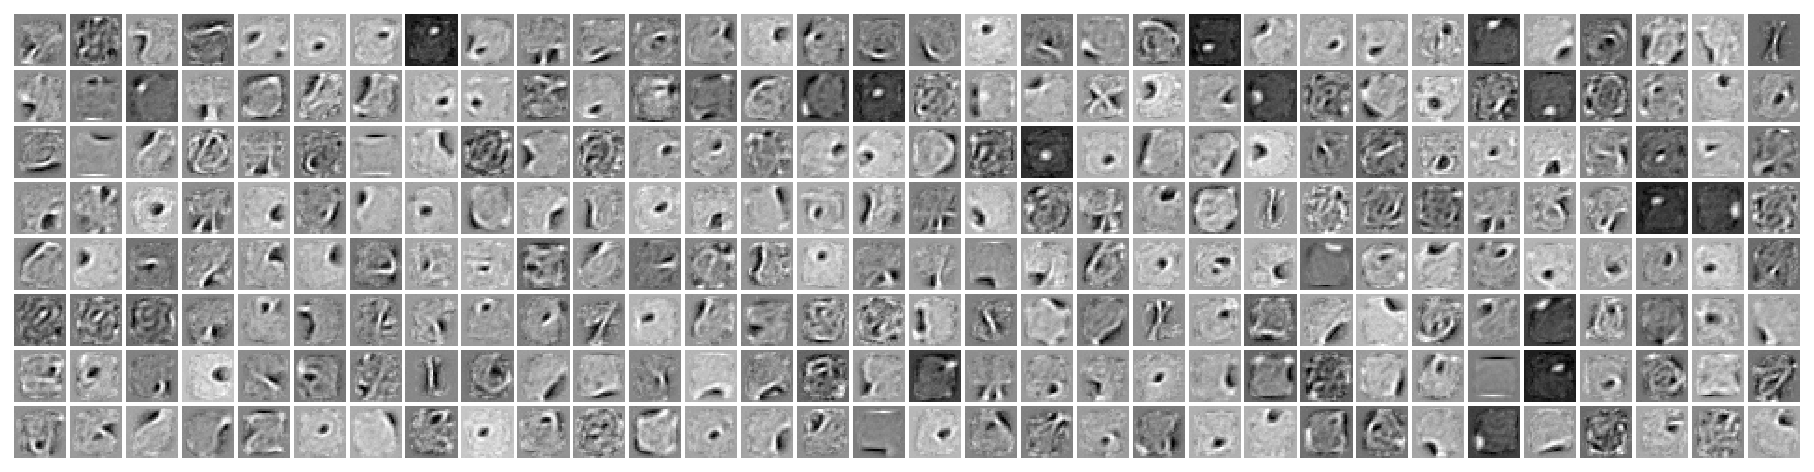

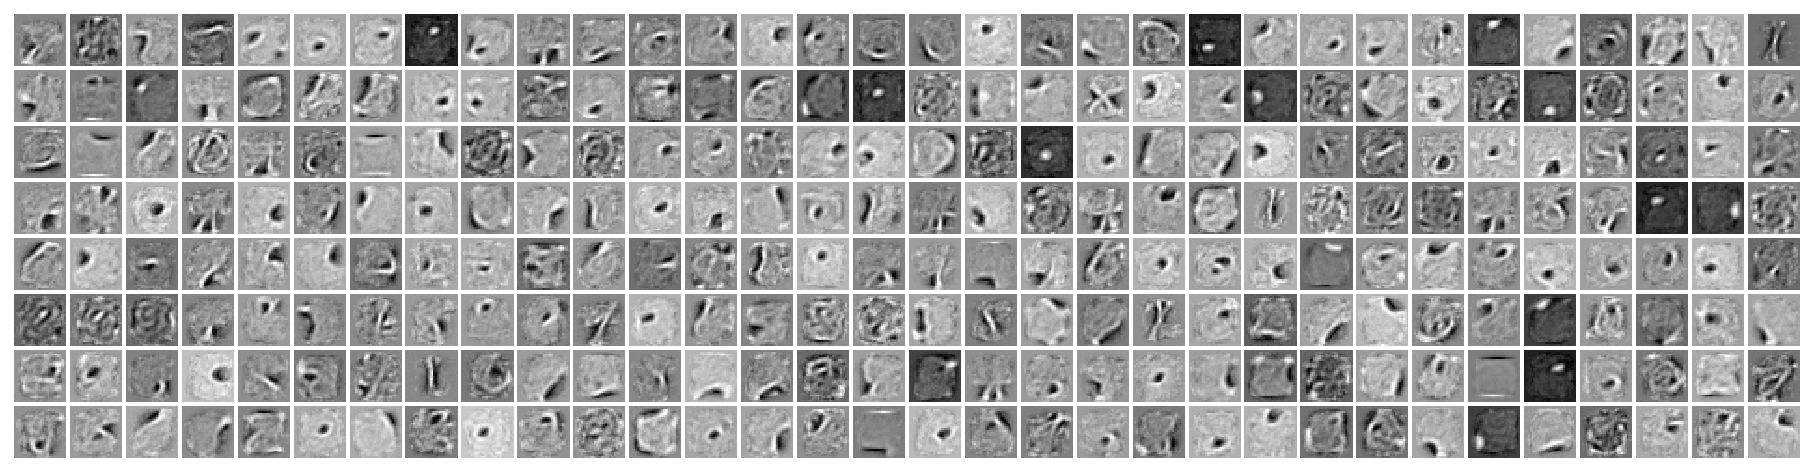

In [43]:
shallow_mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, SOFTMAX_LEARNING_RATE, MOMENTUM, L2_PENALTY)
]

shallow_dbn = [
    Rbm(mlp_layer.visible_size,
        mlp_layer.hidden_size,
        LEARNING_RATE, MOMENTUM, 0.0, L2_PENALTY) for mlp_layer in shallow_mlp[:-1]
]

compare_pretraining_results(shallow_mlp, shallow_dbn,
                            mnist_train_images, mnist_train_labels,
                            mnist_test_images, mnist_test_labels,
                            monitoring_set,
                            BATCH_SIZE, EPOCHS_COUNT)

### Deep neural network

Epoch 1:	########################################	elapsed: 0.69s, accuracy: 10.10
Epoch 2:	########################################	elapsed: 0.69s, accuracy: 10.10
Epoch 3:	########################################	elapsed: 0.70s, accuracy: 8.92
Epoch 4:	########################################	elapsed: 0.70s, accuracy: 8.92
Epoch 5:	########################################	elapsed: 0.73s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.71s, accuracy: 9.74
Epoch 7:	########################################	elapsed: 0.71s, accuracy: 9.74
Epoch 8:	########################################	elapsed: 0.69s, accuracy: 14.12
Epoch 9:	########################################	elapsed: 0.69s, accuracy: 13.94
Epoch 10:	########################################	elapsed: 0.70s, accuracy: 13.88
Epoch 11:	########################################	elapsed: 0.70s, accuracy: 15.59
Epoch 12:	########################################	elapsed: 0.77s, accuracy: 28.02
Epoch 13:	#######

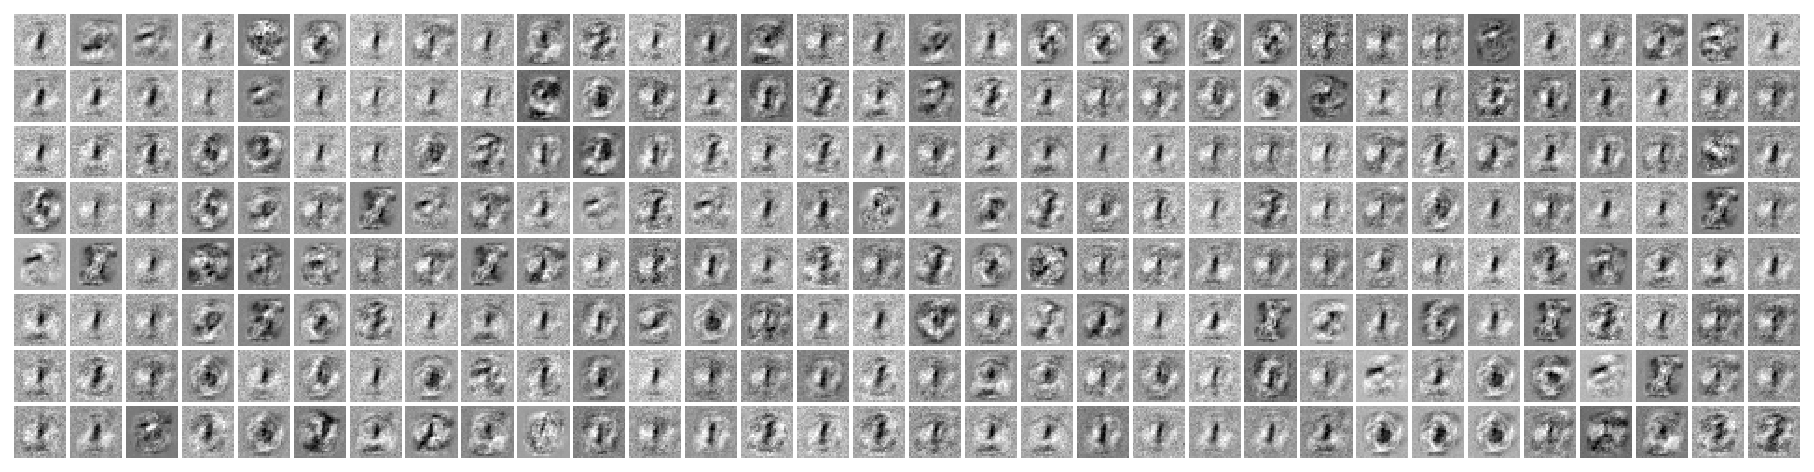


Learning layer 0
Epoch 1:	########################################	elapsed: 1.42s, reconstruction error: 30.66
Epoch 2:	########################################	elapsed: 1.33s, reconstruction error: 22.90
Epoch 3:	########################################	elapsed: 1.34s, reconstruction error: 19.45
Epoch 4:	########################################	elapsed: 1.35s, reconstruction error: 16.81
Epoch 5:	########################################	elapsed: 1.33s, reconstruction error: 15.24
Epoch 6:	########################################	elapsed: 1.39s, reconstruction error: 12.69
Epoch 7:	########################################	elapsed: 1.34s, reconstruction error: 10.74
Epoch 8:	########################################	elapsed: 1.35s, reconstruction error: 9.77
Epoch 9:	########################################	elapsed: 1.34s, reconstruction error: 9.04
Epoch 10:	########################################	elapsed: 1.32s, reconstruction error: 8.53
Epoch 11:	##################################

Epoch 1:	########################################	elapsed: 0.70s, accuracy: 94.24
Epoch 2:	########################################	elapsed: 0.69s, accuracy: 95.28
Epoch 3:	########################################	elapsed: 0.72s, accuracy: 95.74
Epoch 4:	########################################	elapsed: 0.73s, accuracy: 95.94
Epoch 5:	########################################	elapsed: 0.73s, accuracy: 96.16
Epoch 6:	########################################	elapsed: 0.72s, accuracy: 96.25
Epoch 7:	########################################	elapsed: 0.71s, accuracy: 96.39
Epoch 8:	########################################	elapsed: 0.71s, accuracy: 96.41
Epoch 9:	########################################	elapsed: 0.70s, accuracy: 96.52
Epoch 10:	########################################	elapsed: 0.73s, accuracy: 96.58
Epoch 11:	########################################	elapsed: 0.71s, accuracy: 96.62
Epoch 12:	########################################	elapsed: 0.73s, accuracy: 96.68
Epoch 13:	###

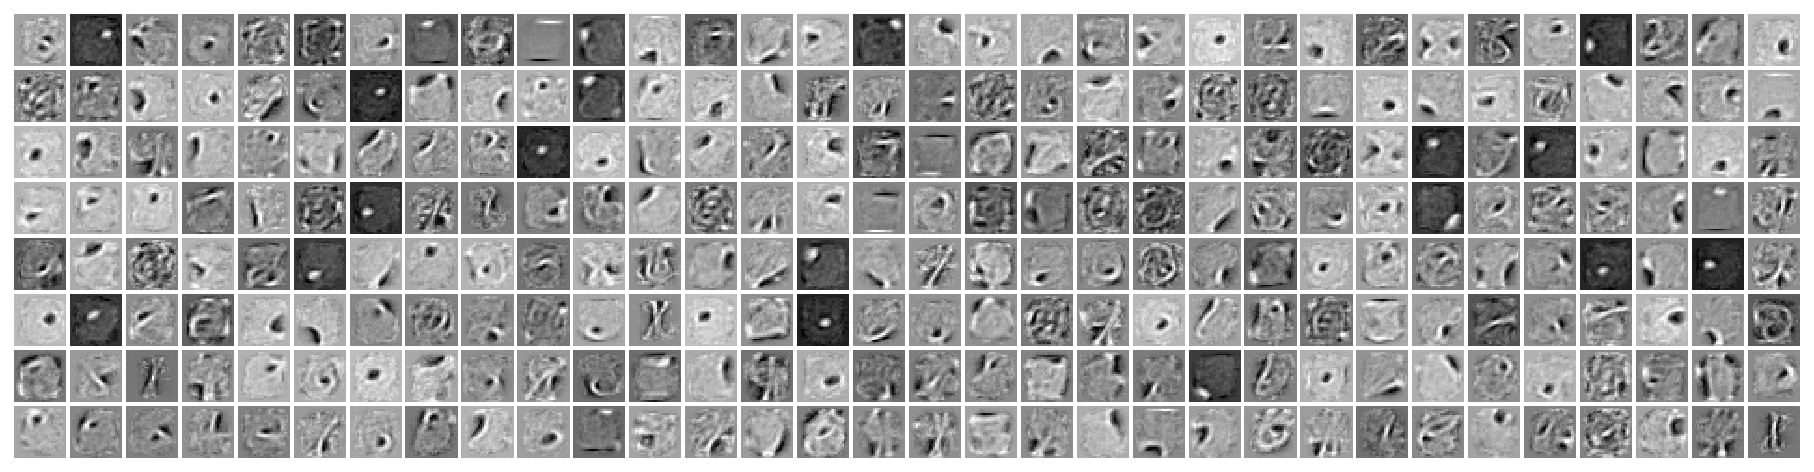

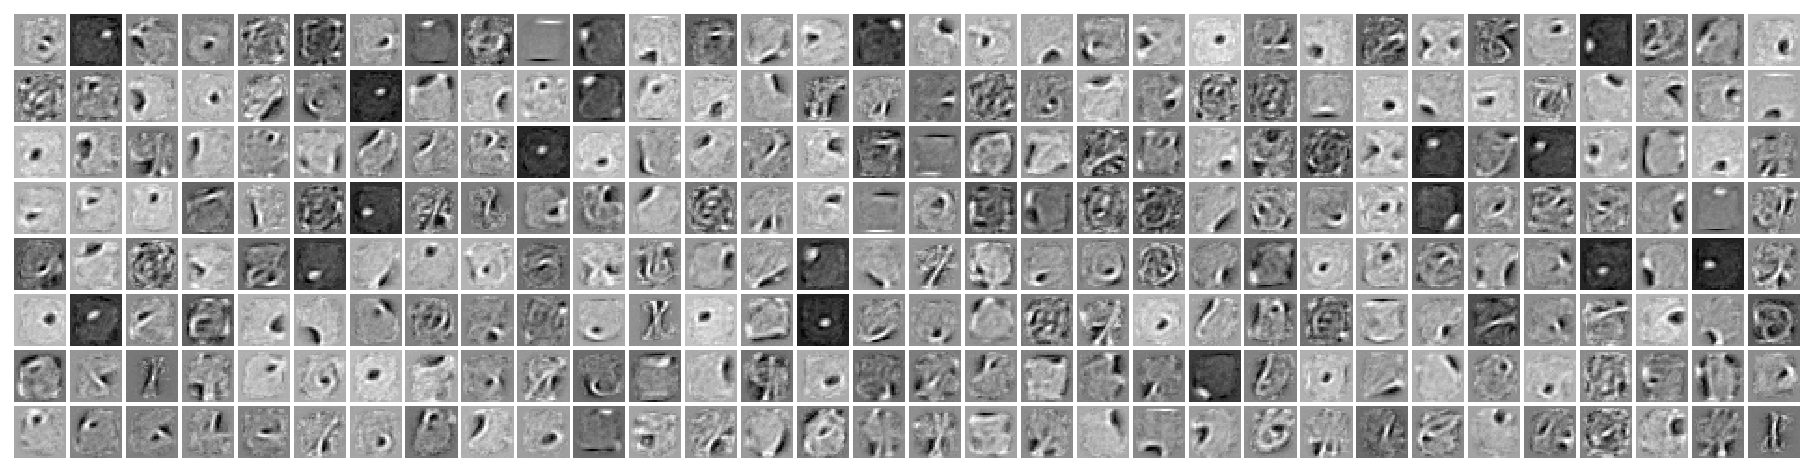

In [44]:
deep_mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, sigmoid_derivative, LEARNING_RATE, MOMENTUM, L2_PENALTY),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, SOFTMAX_LEARNING_RATE, MOMENTUM, L2_PENALTY)
]

deep_dbn = [
    Rbm(mlp_layer.visible_size,
        mlp_layer.hidden_size,
        LEARNING_RATE, MOMENTUM, 0.0, L2_PENALTY) for mlp_layer in deep_mlp[:-1]
]

compare_pretraining_results(deep_mlp, deep_dbn,
                            mnist_train_images, mnist_train_labels,
                            mnist_test_images, mnist_test_labels,
                            monitoring_set,
                            BATCH_SIZE, EPOCHS_COUNT)